#<Center>BREAST TUMOR ULTRASOUND IMAGE CLASSIFICATION </Center>



##OBJECTIVE
The objective of this project is to develop a convolutional neural network model via transfer learning that can classify benign and malignant breast tumor ultrasound images. 

##INTRODUCTION
According to a study by the World Health Organization, there were approximately 2.3 million women diagnosed with breast cancer with 685,000 deaths globally in 2020. Breast cancer treatment has been found to be highly effective following early disease identification. Artificial intelligence can also be leveraged to credibly assist the surgeon in predicting the likelihood of cancer following breast ultrasound examination as preliminary investigative tool. 

######**ARTIFICIAL INTELLIGENCE IN SURGERY**

Artificial intelligence can be defined as the science of making intelligent machines. It is a field of endeavor that essentially strives to inculcate into computers the ability to perform tasks that would ordinarily require human intuition and cognition. It is subdivided into two components namely; machine learning and deep learning. 

The branch of deep learning that utilizes convolutional neural networks to obtain meaningful insight from visual inputs such as image or videos is referred to as Computer Vision. The task of assembling a new convolutional neural network can be described as being more of an art than science and often involves repeated cycles of diligent experimentation and evaluation. Interestingly, one of the many high performance convolutional neural network architectures can be utilized as a template for building a model on custom data instead of re-inventing the wheel. This technique is called transfer learning, and it involves the re-purposing of a model that has been trained on a particular task to a closely related one

The application of AI in surgery is anchored on the desire to enhance treatment in order to improve the clinical outcome. Artificial intelligence can assist the surgeon in the area of screening, treatment and prognostication based on data obtained retrospectively or in real time. Advancing the use of AI in surgery will require addressing issues relating to explainability, ethical constraints and fairness in model development.

##DATA SOURCE 
The ultrasound image data for this project was obtained from https://data.mendeley.com/datasets/wmy84gzngw/1

<br/>

##FURTHER READING
For more useful information about the application of artificial intelligence in medicine, check out my book titled **Frontiers of 21st Century Medicine by Dr Anthony Ukwenya** via the link:
https://www.amazon.com/Frontiers-21st-Century-Medicine-Intelligence-ebook/dp/B09MSW84DS
 
<br/>
<br/>
<br/>
<br/>


##IMPORT THE PREREQUISITE MODULES

In [23]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')
import zipfile
import matplotlib.pyplot as plt
import cv2
import os
import random
from shutil import copyfile
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
import urllib.request



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##DATA EXPLORATION AND ANALYSIS

In [2]:
#Unzip the file the breast cancer dataset uploaded into google drive
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/breast_cancer_image.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/breast_cancer")
zip_ref.close()

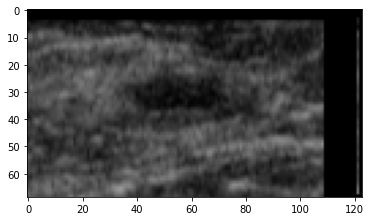

In [3]:
#Read a random image from the benign breast tumor folder
image1 = cv2.imread('/content/drive/MyDrive/breast_cancer/originals/benign/us10.bmp')
benign_breast_image_number_10 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.imshow(benign_breast_image_number_10)

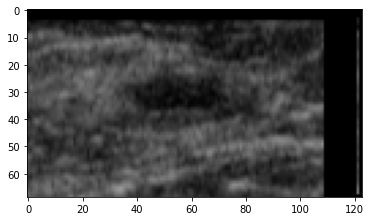

In [4]:
#Read a random image from the benign breast tumor folder
image2 = cv2.imread('/content/drive/MyDrive/breast_cancer/originals/benign/us10.bmp')
benign_breast_image_number_88 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(benign_breast_image_number_88)

In [19]:
#Obtain the shape of the displayed image
benign_breast_image_number_88.shape

(69, 123, 3)

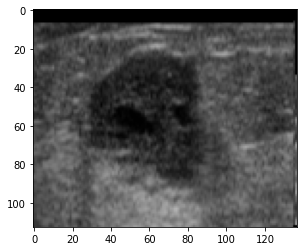

In [5]:
#Read a random image from the malignant breast tumor folder
image3 = cv2.imread('/content/drive/MyDrive/breast_cancer/originals/malignant/us101.bmp')
malignant_breast_image_number_101 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
plt.imshow(malignant_breast_image_number_101)

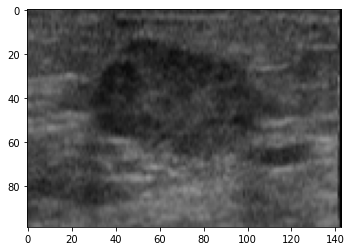

In [6]:
#Read a random image from the malignant breast tumor folder
image4 = cv2.imread('/content/drive/MyDrive/breast_cancer/originals/malignant/us240.bmp')
malignant_breast_image_number_240 = cv2.cvtColor(image4, cv2.COLOR_BGR2RGB)
plt.imshow(malignant_breast_image_number_240)

In [21]:
#Obtain the shape of the previously displayed image
malignant_breast_image_number_240.shape

(113, 137, 3)

In [7]:
# Number of images in the benign and malignant folder
# NB: There is class imbalance which might affect reliability of the model's accuracy
print('The number of benign images are:',len(os.listdir('/content/drive/MyDrive/breast_cancer/originals/benign')))
print('The number of malignant images are:',len(os.listdir('/content/drive/MyDrive/breast_cancer/originals/malignant')))

The number of benign images are: 100
The number of malignant images are: 150


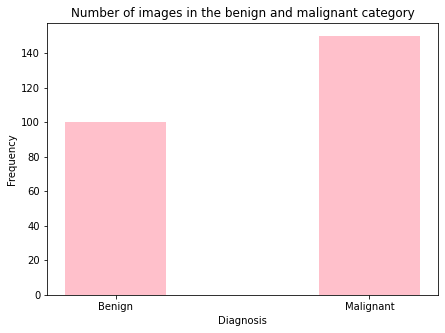

In [11]:
# Visualizing the number of images in both folders
data = {'Benign':100, 'Malignant':150, }
diagnosis = list(data.keys())
frequency = list(data.values())
fig = plt.figure(figsize = (7, 5))
plt.bar(diagnosis, frequency, color ='pink',width = 0.4)
plt.xlabel("Diagnosis")
plt.ylabel("Frequency")
plt.title("Number of images in the benign and malignant category")
plt.show()

In [13]:
#label new folders inorder to split the breast cancer image dataset into train and test
main_folder = '/content/drive/MyDrive/new-breast-cancer-folder'
training_folder = '/content/drive/MyDrive/new-breast-cancer-folder/training'
testing_folder = '/content/drive/MyDrive/new-breast-cancer-folder/testing'
benign_training_folder = '/content/drive/MyDrive/new-breast-cancer-folder/training/benign'
malignant_training_folder = '/content/drive/MyDrive/new-breast-cancer-folder/training/malignant'
benign_testing_folder = '/content/drive/MyDrive/new-breast-cancer-folder/testing/benign'
malignant_testing_folder = '/content/drive/MyDrive/new-breast-cancer-folder/testing/malignant'

#Create the designated folders
os.mkdir(main_folder)
os.mkdir(training_folder)
os.mkdir(testing_folder)
os.mkdir(benign_training_folder)   
os.mkdir(malignant_training_folder)
os.mkdir(benign_testing_folder)
os.mkdir(malignant_testing_folder)

In [14]:
#Create a function that will split image files in the original dataset into training and testing folders 

def split_image_data(source, train, test, split_ratio):
    image_files = []
    for image_file_name in os.listdir(source):
        file = source + image_file_name
        if os.path.getsize(file) > 0:
            image_files.append(image_file_name)
        else:
            print(image_file_name + " is invalid")

    image_training_length = int(len(image_files) * split_ratio)
    image_testing_length = int(len(image_files) - image_training_length)
    shuffled_image_set = random.sample(image_files, len(image_files))
    shuffled_training_set = shuffled_image_set[0:image_training_length]
    shuffled_testing_set = shuffled_image_set[image_training_length:]
    
    for image in shuffled_training_set:
          origin = source + image
          destination_folder = train + image
          copyfile(origin, destination_folder)

    for image in shuffled_testing_set:
          origin = source + image
          destination_folder = test + image
          copyfile(origin, destination_folder)

In [ ]:
#Get the path of the newly created folders
benign_image_dir = '/content/drive/MyDrive/breast_cancer/originals/benign/'
training_benign_dir = '/content/drive/MyDrive/new-breast-cancer-folder/training/benign/'
testing_benign_dir = '/content/drive/MyDrive/new-breast-cancer-folder/testing/benign/'
malignant_image_dir = '/content/drive/MyDrive/breast_cancer/originals/malignant/'
training_malignant_dir = '/content/drive/MyDrive/new-breast-cancer-folder/training/malignant/'
testing_malignant_dir = '/content/drive/MyDrive/new-breast-cancer-folder/testing/malignant/'

In [15]:
#Execute the split function via the split ratio of choice
split_ratio = 0.8
split_image_data(benign_image_dir, training_benign_dir, testing_benign_dir, split_ratio)
split_image_data(malignant_image_dir, training_malignant_dir, testing_malignant_dir, split_ratio)

In [18]:
#Check the number of image files in their respective folders
print("Number of training images in the benign category:", len(os.listdir(training_benign_dir)))
print("Number of training images in the malignant category:", len(os.listdir(training_malignant_dir)))
print("Number of testing images in the benign category:", len(os.listdir(testing_benign_dir)))
print("Number of testing images in the malignant category:", len(os.listdir(testing_malignant_dir)))

Number of training images in the benign category: 80
Number of training images in the malignant category: 120
Number of testing images in the benign category: 20
Number of testing images in the malignant category: 30


##DATA PREPROCESSING AND AUGMENTATION

In [41]:
#Augment data via ImageDataGenerator to checkmate class imbalance and increase dataset size
training_set_generator = ImageDataGenerator(
      rescale = 1/255,
      validation_split = 0.2
    )
train_images = training_set_generator.flow_from_directory(training_folder,
                                                          batch_size=100,
                                                          class_mode='binary', 
                                                          target_size=(120, 120))


testing_set_datagen = ImageDataGenerator(
    rescale = 1/255
    )
test_images = testing_set_datagen.flow_from_directory(testing_folder,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(120, 120))



Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [24]:
#Obtain inceptionv3 model for transfer learning
pretrained_weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights = "inception_v3.h5"
urllib.request.urlretrieve(pretrained_weights_url, weights)

#instantiate the model following retrieval
pretrained_inceptionV3_model = InceptionV3(input_shape=(120, 120, 3),
                                include_top=False,
                                weights=None)
pretrained_inceptionV3_model.load_weights(weights)

for layer in pretrained_inceptionV3_model.layers:
    layer.trainable = False

layer = pretrained_inceptionV3_model.get_layer('mixed7')
last_output = layer.output

In [40]:
# Create new  convolutional neural network layers and add to the preexisting architecture 
layer1 = layers.Flatten()(last_output)
layer2 = layers.Dense(1000, activation='relu')(layer1)
layer3 = layers.Dense(100, activation='relu')(layer2)
layer4 = layers.Dense(10, activation='relu')(layer3)
layer5 = layers.Dense(1, activation='sigmoid')(layer4)

model = Model(pretrained_inceptionV3_model.input, layer5)


##MODELLING

In [58]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 59, 59, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 59, 59, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [42]:
#Compile the model 
model.compile(optimizer=RMSprop(),
              loss='binary_crossentropy',
              metrics=['acc'])
#Fit the model
history = model.fit(
            train_images,
            validation_data = test_images,
            epochs=20,
            verbose=1)

Epoch 1/20
2/2 [==============================] - 11s 5s/step - loss: 4.0149 - acc: 0.5000 - val_loss: 0.8183 - val_acc: 0.6000
Epoch 2/20
2/2 [==============================] - 6s 4s/step - loss: 0.7312 - acc: 0.6000 - val_loss: 0.6610 - val_acc: 0.6000
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 0.6538 - acc: 0.6000 - val_loss: 0.6392 - val_acc: 0.6000
Epoch 4/20
2/2 [==============================] - 6s 3s/step - loss: 0.6267 - acc: 0.6000 - val_loss: 0.6193 - val_acc: 0.7800
Epoch 5/20
2/2 [==============================] - 6s 4s/step - loss: 0.6313 - acc: 0.6500 - val_loss: 0.6474 - val_acc: 0.8800
Epoch 6/20
2/2 [==============================] - 6s 4s/step - loss: 0.6073 - acc: 0.7400 - val_loss: 0.5893 - val_acc: 0.7800
Epoch 7/20
2/2 [==============================] - 6s 3s/step - loss: 0.6155 - acc: 0.6800 - val_loss: 0.6518 - val_acc: 0.7200
Epoch 8/20
2/2 [==============================] - 6s 3s/step - loss: 0.5782 - acc: 0.7450 - val_loss: 0.5467 -

## MODEL EVALUATION


In [56]:
#Check the accuracy of the model
test_accuracy = history.history['val_acc']
test_accuracy

[0.6000000238418579,
 0.6000000238418579,
 0.6000000238418579,
 0.7799999713897705,
 0.8799999952316284,
 0.7799999713897705,
 0.7200000286102295,
 0.7200000286102295,
 0.6600000262260437,
 0.6000000238418579,
 0.6000000238418579,
 0.7400000095367432,
 0.7400000095367432,
 0.8600000143051147,
 0.7400000095367432,
 0.9399999976158142,
 0.4000000059604645,
 0.4399999976158142,
 0.9399999976158142,
 0.9800000190734863]

In [60]:
#Save and download the model
model.save('my_model.h5')
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##CONCLUSION

The trained model had a very good accuracy score on the validation dataset 95% and 98% on the test set for the purpose of classifying benign and malignant images.

## Author 

Anthony Ukwenya

##Credit

1. Deep Learning for Computer Vision by Jason Brownlee.
2. Deep Learning with Python by Francois Chollet.
3. Hands on Machine Learning with ScikitLearn, Keras and Tensorflow by Aurelien Geron.
4. Advanced Computer Vision with Tensorflow (Coursera).
5. AI for Medicine Specialization (Coursera).
6. Python for Computer Vision by Jose Portilla (Udemy).
7. Rodrigues, Paulo Sergio (2017), “Breast Ultrasound Image”, Mendeley Data, V1, doi: 10.17632/wmy84gzngw.1



